<center><h1>Proyecto #2</h1></center>
<center><h1>Ingeniería de datos</h1></center>

## Jesus Enrique Ponte Bravo 23002672
## Maria Alejandra Morales Miranda 23000228
## Sergio Daniel Gonzales Lopez 23004069

## Importación de librerías a utilizar en el proyecto
Se utiliza la librería boto3 para realizar la conexión con RDS y de esta forma traer los archivos del bucket.
pandas para realizar la creación de los dataframes, la transformación de los datos y las uniones entre diferentes tablas.

In [262]:
import boto3
import pandas as pd
import numpy as np
import io

Se realiza la conexión a S3 usando boto3, revisando que esten los documentos necesarios para hacer la extracción.

In [263]:
client = boto3.client("s3")
s3 = boto3.resource('s3')
path = 's3://saludmental/question.csv'

for bucket in s3.buckets.all():
    print(bucket.name)
    my_bucket = s3.Bucket(bucket.name)
    for file in my_bucket.objects.all():
        print(file.key)

saludmental
answer.csv
question.csv
survey.csv


De la conexión generada obtenemos del bucket saludmental el csv: question. El cual se transforma en csv usando pandas y se muestra.

In [264]:
obj = client.get_object(Bucket='saludmental', Key='question.csv')
response = obj['Body']
question = pd.read_csv(response)
print(question)

                                          questiontext  questionid
0                                    What is your age?           1
1                                 What is your gender?           2
2                         What country do you live in?           3
3    If you live in the United States, which state ...           4
4                               Are you self-employed?           5
..                                                 ...         ...
100  Do you think that team members/co-workers woul...         114
101  If yes, what condition(s) have you been diagno...         115
102  If maybe, what condition(s) do you believe you...         116
103  Which of the following best describes your wor...         117
104                              Do you work remotely?         118

[105 rows x 2 columns]


De la conexión generada obtenemos del bucket saludmental el csv: answer. El cual se transforma en csv usando pandas y se muestra.

In [265]:
obj = client.get_object(Bucket='saludmental', Key='answer.csv')
response = obj['Body']
answer = pd.read_csv(response)
print(answer)

                AnswerText  SurveyID  UserID  QuestionID
0                       37      2014       1           1
1                       44      2014       2           1
2                       32      2014       3           1
3                       31      2014       4           1
4                       31      2014       5           1
...                    ...       ...     ...         ...
236893               Other      2016    2689         117
236894             Support      2016    2690         117
236895  Back-end Developer      2016    2691         117
236896     DevOps/SysAdmin      2016    2692         117
236897               Other      2016    2693         117

[236898 rows x 4 columns]


### Se realiza la conexión a la base de datos

In [266]:
import psycopg2 as ps

# define credentials
credentials = {} # change to your db name
# create connection and cursor
conn = ps.connect(host=credentials['POSTGRES_ADDRESS'],
                  database=credentials['POSTGRES_DBNAME'],
                  user=credentials['POSTGRES_USERNAME'],
                  password=credentials['POSTGRES_PASSWORD'],
                  port=credentials['POSTGRES_PORT'])
cur = conn.cursor()

#Query de la tabla de answer
query = """SELECT * FROM Survey;"""

survey = pd.read_sql_query(query, conn)
print(survey)
#cur.execute(query)
#cur.fetchall()

   surveyid                    description
0      2014  mental health survey for 2014
1      2016  mental health survey for 2016
2      2017  mental health survey for 2017
3      2018  mental health survey for 2018
4      2019  mental health survey for 2019


C:\Users\JesúsPonte\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## INICIO DE EDA

## Question table
Posee dos columnas las cuales son:
questiontext: Posee la pregunta realizada en la encuesta.
questionid: posee el id de forma numerica de la pregunta realizada.

In [267]:
question

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


In [268]:
print("El numero de preguntas en de las encuestas es de: ", len(question))

El numero de preguntas en de las encuestas es de:  105


# Survey table
Posee dos columnas con lo siguiente:
SurveyID: Posee el año en el cual se realizó la encuesta.
Description: Una descripción basica en la cual colocan el nombre de la encuesta realizada.

In [269]:
survey

,surveyid,description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


SurveyID representa el año de la encuesta realizada y sirve de ID.

## Answer table
Tabla de respuestas, la cual es la más importante del modelo. Posee las siguientes columnas:
AnswerText: Contiene la respuesta del usuario.
SurveyID: Contiene el id de la encuesta que representa el año.
UserID: El id del usuario que respondió la encuesta.
QuestionID: El id de la pregunta realizada.

In [270]:
answer

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


In [271]:
answer.UserID.nunique()

4218

## Se realiza un analisis de la distribución de las respuestas a la encuesta por año, para conocer cuantos participaron.

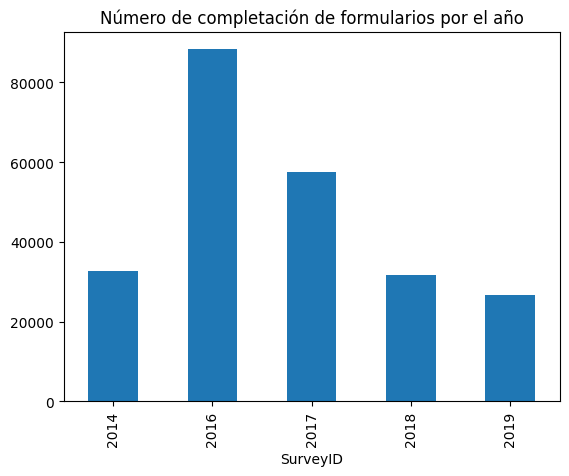

In [272]:
dist_survey = answer.groupby('SurveyID')['UserID'].count().plot.bar(title='Número de completación de formularios por el año')

## Se realiza un join con answer y question. El cual nos permite tener una dataframe con el userID, questionText y AnswerText.

In [273]:
df_join = pd.merge(answer,question,left_on='QuestionID', right_on='questionid')
df_join

,AnswerText,SurveyID,UserID,QuestionID,questiontext,questionid
0,37,2014,1,1,What is your age?,1
1,44,2014,2,1,What is your age?,1
2,32,2014,3,1,What is your age?,1
3,31,2014,4,1,What is your age?,1
4,31,2014,5,1,What is your age?,1
...,...,...,...,...,...,...
236893,Other,2016,2689,117,Which of the following best describes your wor...,117
236894,Support,2016,2690,117,Which of the following best describes your wor...,117
236895,Back-end Developer,2016,2691,117,Which of the following best describes your wor...,117
236896,DevOps/SysAdmin,2016,2692,117,Which of the following best describes your wor...,117


### Revisamos los tipos de datos que se tienen en el dataframe, observando que answer text y question text por ser strings pandas los coloca como "object"

In [274]:
df_join.dtypes

AnswerText      object
SurveyID         int64
UserID           int64
QuestionID       int64
questiontext    object
questionid       int64
dtype: object

### Se tiene la primera pregunta, El cual es ¿Cúal es tu edad?.
### Se filtra tal que solo tenemos las respuestas la pregunta 1. Se agrupa por answerText(edad) y se cuentan los rows, Ordenado por AnswerText(edad) de forma descendente.
### Se filtra para obtener las respuestas de los usuarios mayores de 18 años y menores de 100.

In [275]:
question_1 = df_join[(df_join.questionid == 1)].sort_values(by='AnswerText', ascending=False).groupby('AnswerText')['SurveyID'].count().reset_index()
question_1 = question_1.astype({'AnswerText': 'int32'})
question_1 = question_1[ (question_1.AnswerText >= 18) & (question_1.AnswerText <= 100)]
question_1

,AnswerText,SurveyID
6,18,9
7,19,20
8,20,17
9,21,39
10,22,74
11,23,107
12,24,128
13,25,147
14,26,194
15,27,197


### Se realiza un grafico de barras que nos permite observar la distribución de las edades de las personas que respondieron la encuesta.
### siendo "x" las edades y "y" la cantidad de personas con esa edad.

<AxesSubplot: title={'center': 'Dist de edades'}, xlabel='Edades', ylabel='Cantidad de personas'>

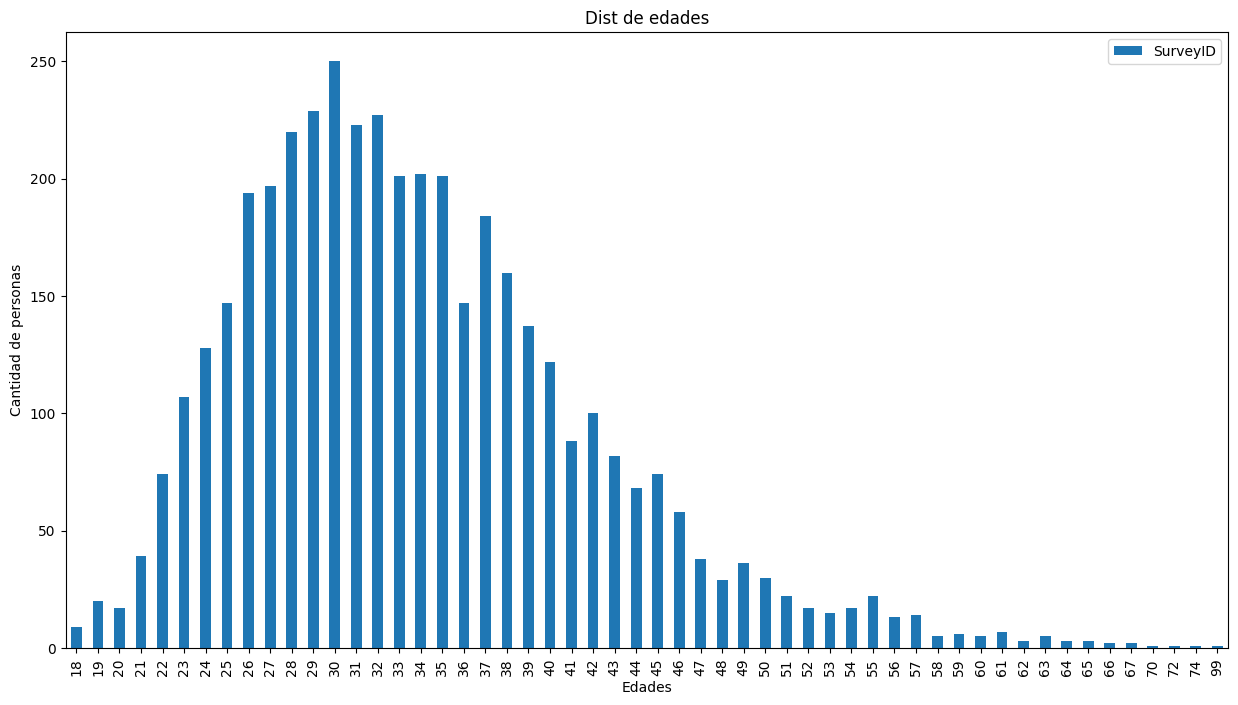

In [276]:
question_1.plot.bar(x='AnswerText', y='SurveyID', xlabel='Edades', ylabel='Cantidad de personas', title='Dist de edades', figsize=(15,8))

## Pregunta 2
# ¿Trabajas remotamente?
Se filtra por questionId == 118. Agrupando y contando los rows por cada tipo de respuesta. Notando que tenemos solo 3 tipos, Always, never y Sometimes.

In [277]:
question_2 = df_join[(df_join.questionid == 118)].groupby('AnswerText')['SurveyID'].count().reset_index()
question_2

,AnswerText,SurveyID
0,Always,343
1,Never,333
2,Sometimes,757


### Se realiza un grafico de barras el cual muestra la distribución de las respuestas si trabajan remotamente, lo cual tiene la cantidad de todos los años de las diferentes encuestas.

<AxesSubplot: title={'center': 'Cantidad de personas que prefieren trabajar de forma remota'}, xlabel='Respuesta', ylabel='Cantidad de personas'>

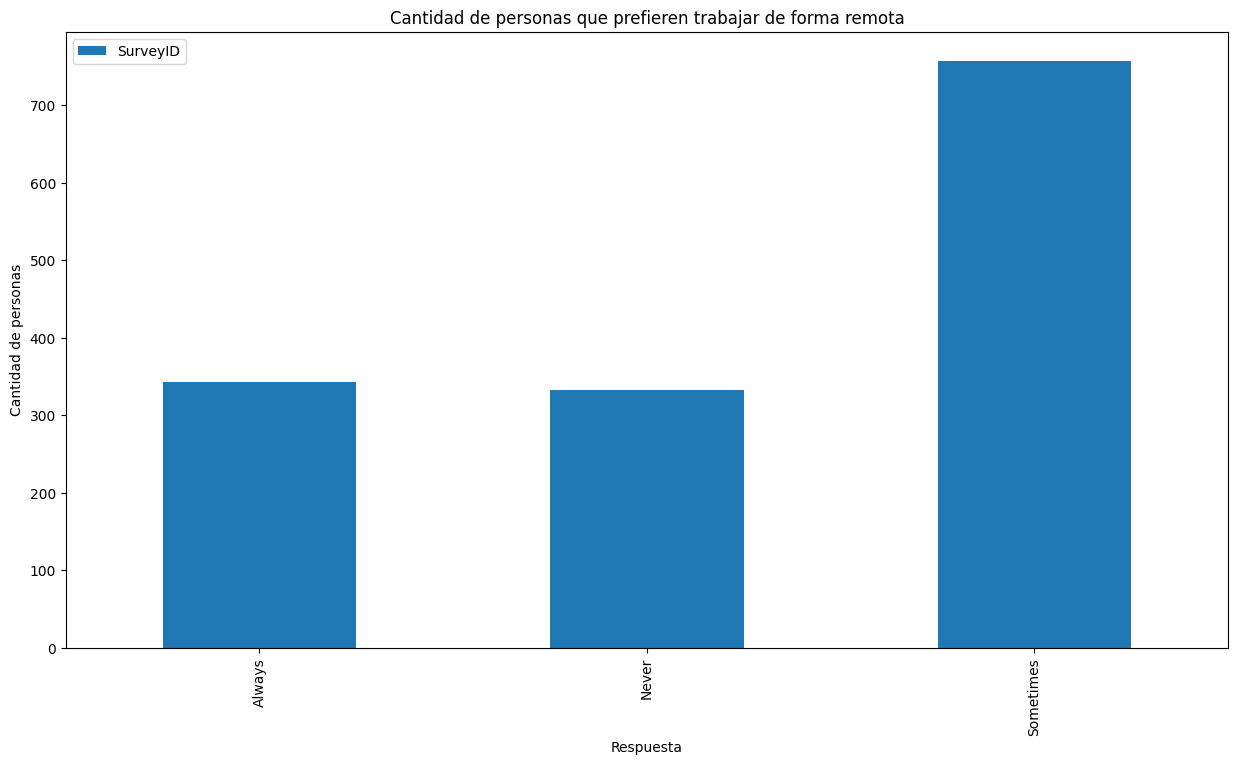

In [278]:
question_2.plot.bar(x='AnswerText', y='SurveyID', xlabel='Respuesta', ylabel='Cantidad de personas', title='Cantidad de personas que prefieren trabajar de forma remota', figsize=(15,8))


## Pregunta 3
# ¿Cual es tu genero?

Se realiza una copia del dataframe ya que se debe realizar un filtro por genero, ya que las entradas para esta pregunta son mixtas debido a la libertad de respuesta permitida.

In [279]:
question_3 = df_join[(df_join.questionid == 2)].copy()
question_3

,AnswerText,SurveyID,UserID,QuestionID,questiontext,questionid
4218,Female,2014,1,2,What is your gender?,2
4219,Male,2014,2,2,What is your gender?,2
4220,Male,2014,3,2,What is your gender?,2
4221,Male,2014,4,2,What is your gender?,2
4222,Male,2014,5,2,What is your gender?,2
...,...,...,...,...,...,...
8431,male,2019,4214,2,What is your gender?,2
8432,Male,2019,4215,2,What is your gender?,2
8433,Male,2019,4216,2,What is your gender?,2
8434,female,2019,4217,2,What is your gender?,2


Función gender_filter, el cual recibe el row del dataframe y dependiendo del contenido retorna el valor que corresponde al genero.
Se crea una nueva columna en el dataframe y se coloca el nuevo valor utilizado para normalizar los datos.

In [280]:
def gender_filter(x):
    if ('female' in x) or ('Female' in x):
        return 'Female'
    elif ('male' in x) or ('Male' in x):
        return 'Male'
    elif 'queer' in x:
        return 'Queer'
    elif ('non binary' in x) or ('non-binary' in x) or ('nonbinary' in x):
        return 'Non-binary'
    elif ('trans' in x) or ('Trans' in x):
        return 'Trans'
    elif ('Agender' in x):
        return 'Agender'
    elif 'Androgyn' in x:
        return 'Angrogynous'
    elif 'fluid' in x:
        return 'Genderfluid'
    else:
        return 'Other'

question_3['Gender'] = question_3['AnswerText'].apply(gender_filter)
question_3

,AnswerText,SurveyID,UserID,QuestionID,questiontext,questionid,Gender
4218,Female,2014,1,2,What is your gender?,2,Female
4219,Male,2014,2,2,What is your gender?,2,Male
4220,Male,2014,3,2,What is your gender?,2,Male
4221,Male,2014,4,2,What is your gender?,2,Male
4222,Male,2014,5,2,What is your gender?,2,Male
...,...,...,...,...,...,...,...
8431,male,2019,4214,2,What is your gender?,2,Male
8432,Male,2019,4215,2,What is your gender?,2,Male
8433,Male,2019,4216,2,What is your gender?,2,Male
8434,female,2019,4217,2,What is your gender?,2,Female


### Se agrupan las respuestas de los generos y se cuentan los rows para así obtener el número por genero, ordenado de forma ascendente.

In [281]:
question_3 = question_3.groupby('Gender')['SurveyID'].count().reset_index().sort_values('SurveyID', ascending=False)
question_3

,Gender,SurveyID
4,Male,3052
2,Female,1037
6,Other,85
7,Queer,11
8,Trans,11
5,Non-binary,9
3,Genderfluid,6
0,Agender,5
1,Angrogynous,2


### Se realiza un grafico de barras para conocer cual es la distribución de los generos de las personas que respondieron la encuesta.

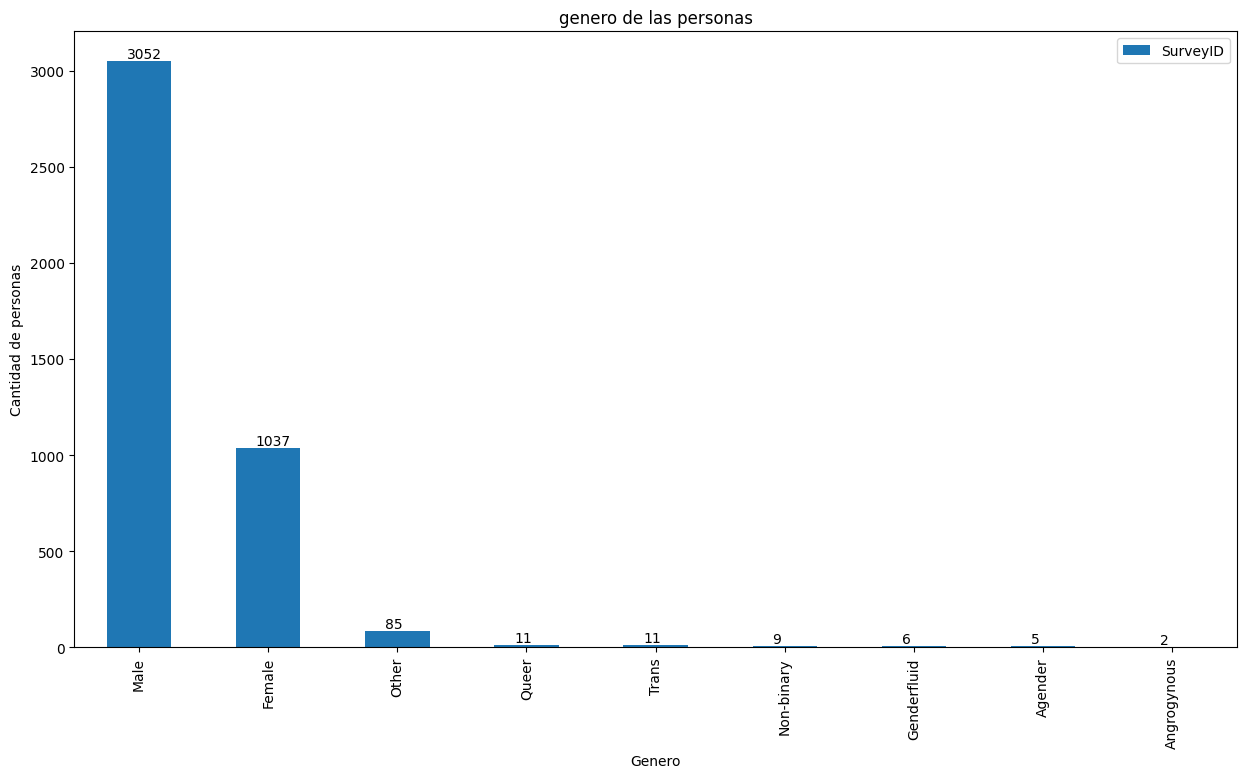

In [282]:
ax = question_3.plot.bar(x='Gender', y='SurveyID', xlabel='Genero', ylabel='Cantidad de personas', title='genero de las personas', figsize=(15,8))

x_offset = -0.095
y_offset = 15

for p in ax.patches:
    b = p.get_bbox()
    val = "{:1.0f}".format(b.y1 + b.y0)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

## Pregunta 4
# ¿Cuantas empleados conforman tu compañía o empresa?

Se filtran columnas en la cual habían valores que no son correctos. Se agrupa por respuesta y año, contando la cantidad de usuarios y ordenando de menor a mayor.
Se hace un pivot para poder tener los años en columna.

In [283]:
question_4 = df_join[(df_join.questionid == 8)].copy()
question_4 = question_4[question_4['AnswerText'] != '-1']
question_4 = question_4.groupby(['AnswerText', 'SurveyID'])['UserID'].count().reset_index().sort_values('SurveyID', ascending=False)
question_4 = question_4.pivot(index='AnswerText', columns='SurveyID', values='UserID')
question_4

SurveyID,2014,2016,2017,2018,2019
AnswerText,,,,,
1-5,162,60,20,5,7
100-500,176,248,203,81,80
26-100,289,292,128,70,45
500-1000,61,80,48,31,27
6-25,290,210,86,69,34
More than 1000,282,256,158,105,111


### Se crea una grafica en la cual se muestra la cantidad de empleados por el tamaño de la empresa por año.

<AxesSubplot: title={'center': 'Cantidad de empleados y empresas que los emplean'}, xlabel='Cantidad de empleados', ylabel='Cantidad de empresas'>

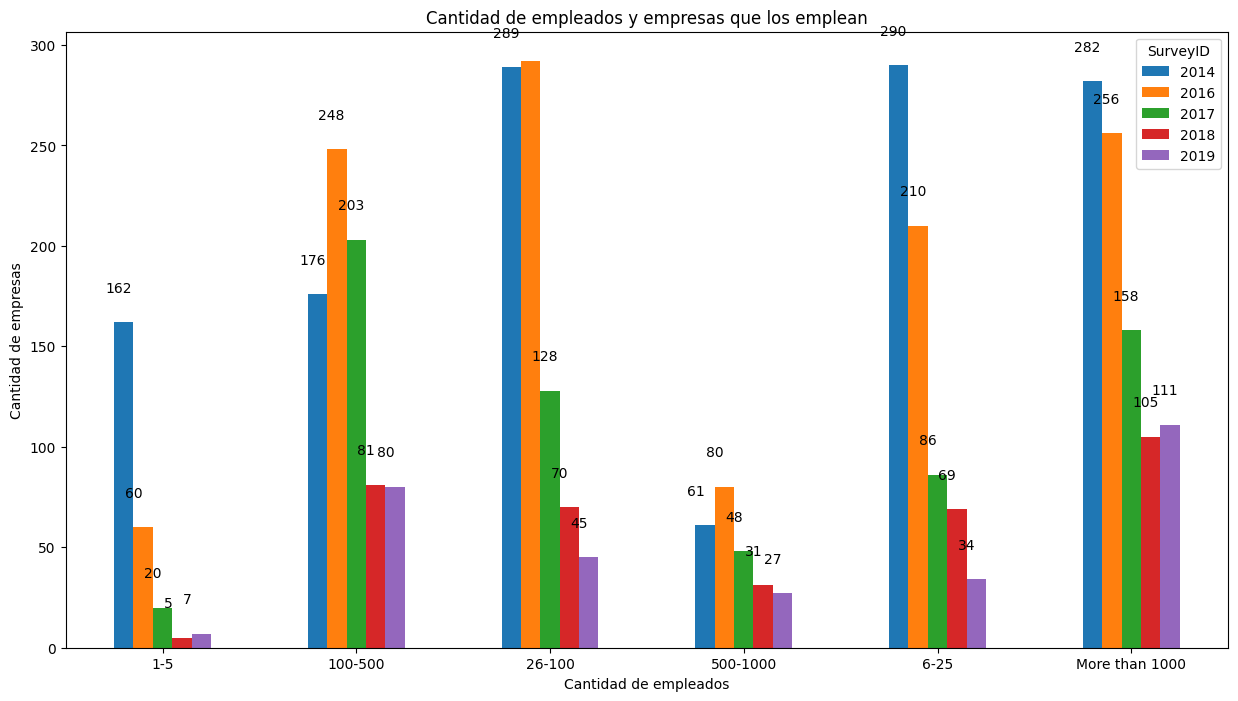

In [284]:
ax = question_4.plot.bar(rot=0, xlabel='Cantidad de empleados', ylabel='Cantidad de empresas', title='Cantidad de empleados y empresas que los emplean', figsize=(15,8))
x_offset = -0.095
y_offset = 15

for p in ax.patches:
    b = p.get_bbox()
    val = "{:1.0f}".format(b.y1 + b.y0)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax

## Pregunta 5
# ¿Posees algún tipo de desorden mental?

In [285]:
question_5 = df_join[(df_join.questionid == 33)].copy()
question_5 = question_5.groupby('AnswerText')['UserID'].count().reset_index().sort_values('UserID', ascending=False).set_index("AnswerText")
question_5

,UserID
AnswerText,
Yes,1237
No,969
Maybe,327
Possibly,301
Don't Know,124


<AxesSubplot: title={'center': 'Personas que poseen un desorden mental'}, ylabel='UserID'>

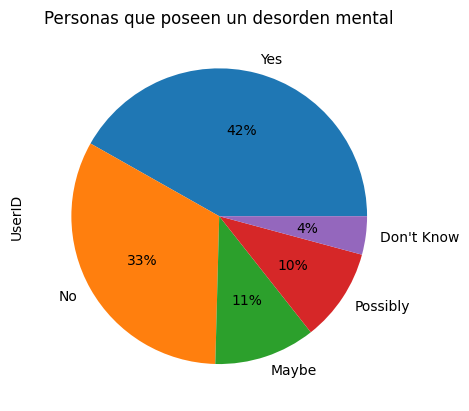

In [286]:
question_5.plot.pie(y='UserID', title='Personas que poseen un desorden mental', legend=False,  autopct='%1.0f%%')

## Pregunta 6
# ¿Has discutido sobre tu salud mental con tu empleador?

In [287]:
def binary_filter(x):
    if x == '0':
        return "No"
    else:
        return "Yes"

question_6 = df_join[(df_join.questionid == 58)].copy()
question_6 = question_6[question_6['AnswerText'] != '-1']
question_6['Answer'] = question_6['AnswerText'].apply(binary_filter)
question_6 = question_6.groupby('Answer')['UserID'].count().reset_index().sort_values('UserID', ascending=False).set_index("Answer")
question_6

,UserID
Answer,
No,886
Yes,422


<AxesSubplot: title={'center': '¿Has discutido sobre tu salud mental con tu empleador?'}, ylabel='UserID'>

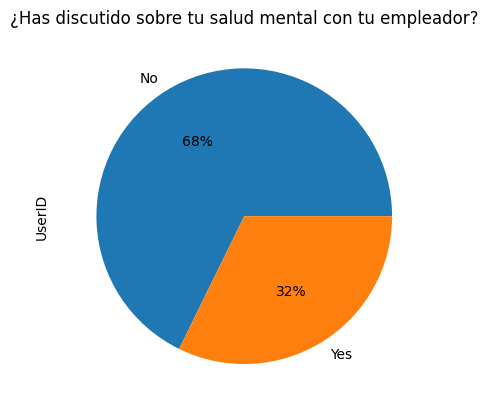

In [288]:
question_6.plot.pie(y='UserID', title='¿Has discutido sobre tu salud mental con tu empleador?', legend=False,  autopct='%1.0f%%')
